# pNML Min Norm Viz

In [1]:
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, "../src/")
import data_utils
from post_simulation_utils import load_simulation_results, calc_nf_from_genie_files, calc_nf_from_single_genie_file
from pnml_min_norm_utils import PnmlMinNorm, calc_analytic_norm_factor
from pnml_min_norm_utils import calc_gamma_0_norm_factor, calc_x_bot_square


In [2]:
# Plot params
mpl.style.use("seaborn-dark")
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['figure.dpi'] = 85
mpl.rcParams['axes.labelsize'] = 'large'


# Load simulation resutls

In [3]:
base_dir_list = [    
    osp.join("..", "output", "20200507_134304"),
    osp.join("..", "output", "20200507_134558"),
    osp.join("..", "output", "20200507_141909"),
]


In [4]:
res_list = [load_simulation_results(base_dir) for base_dir in base_dir_list]
for res in res_list:
    print('model_degree={} x_train={}'.format(res['model_degree'], res['x_train']))

print()
print(res_list[0].keys())


model_degree=2 x_train=[0.055, 0.655, 0.855, 0.995]
model_degree=6 x_train=[0.055, 0.655, 0.855, 0.995]
model_degree=10 x_train=[0.055, 0.655, 0.855, 0.995]

dict_keys(['model_degree', 'x_test', 'regret', 'y_hat_erm', 'x_train', 'y_train', 'base_dir', 'genies_output_path', 'params'])


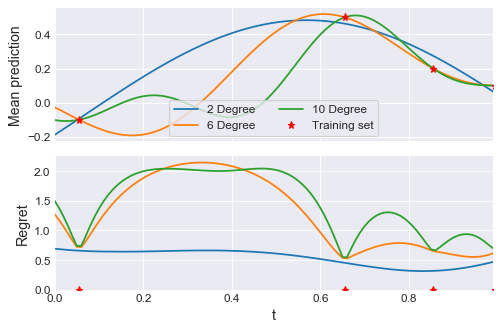

In [5]:
x_train, y_train = res_list[0]["x_train"], res_list[0]["y_train"]

fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
for res in res_list:
    ax.plot(res["x_test"], res["y_hat_erm"], label=r"{} Degree".format(res["model_degree"]))
ax.plot(x_train, y_train, "r*", label="Training set")
ax.set_ylabel("Mean prediction")
ax.legend(loc=8,ncol=2)
# ax.set_ylim(-20,20)
ax.set_xlim(res["x_test"][0],res["x_test"][-1])

ax = axs[1]
for res in res_list:
    ax.plot(res["x_test"], res["regret"])
ax.plot(x_train, [0] * len(y_train), "r*")
ax.set_ylim(bottom=0.0)
ax.set_ylabel("Regret")
ax.set_xlabel("t")
plt.tight_layout()
plt.show()


# Simulation Vs Analytical

In [6]:
# Choosing which simulation to analyze 
res = res_list[2]
x_train, y_train = res['x_train'], res['y_train']
model_deg = res['model_degree']
print('model_degree={} x_train={}'.format(x_train, model_deg))
sigma_square = res['params']['min_sigma_square']

model_degree=[0.055, 0.655, 0.855, 0.995] x_train=10


In [7]:
# Create data
DataC = data_utils.data_type_dict[res['params']['data_type']]
data_h = DataC(x_train, y_train, model_deg)
phi_train = data_h.phi_train

# Calculate minimum norm solution
pnml_h = PnmlMinNorm(1.0, phi_train, y_train, 0.0, sigma_square)
theta_mn = pnml_h.theta_erm

# Calculate analytical regret
phi_tests = [data_h.convert_point_to_features(x, model_deg) for x in res['x_test']]
norm_factors = [calc_analytic_norm_factor(phi_train, 
                                          phi_test, 
                                          theta_mn,sigma_square) for phi_test in phi_tests]
regrets = np.log(norm_factors)

# Check
for x_test,nf in zip(res['x_test'],norm_factors):
    if nf < 1:
        print('Warning at x_test={}. norm factor={}'.format(x_test,nf))

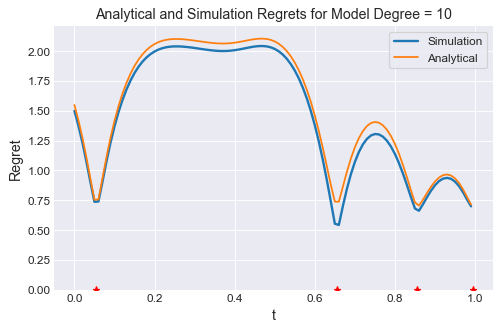

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(res["x_test"], res["regret"], label='Simulation', linewidth=2.0)
ax.plot(res["x_test"], regrets, label='Analytical')
ax.plot(x_train, [0] * len(y_train), "r*")
ax.set_ylim(bottom=0.0)
ax.set_ylabel("Regret")
ax.set_xlabel("t")
plt.title('Analytical and Simulation Regrets for Model Degree = {}'.format(model_deg))
plt.legend()
plt.tight_layout()
plt.show()


## Changing $\sigma^2$

In [9]:
sigma_squares = [1e-1, 1e-2, 1e-3]
regret_list = []
for sigma_square in sigma_squares:
    regret, debug_list = calc_nf_from_genie_files(res['genies_output_path'], sigma_square)
    regret_list.append(regret)


[]

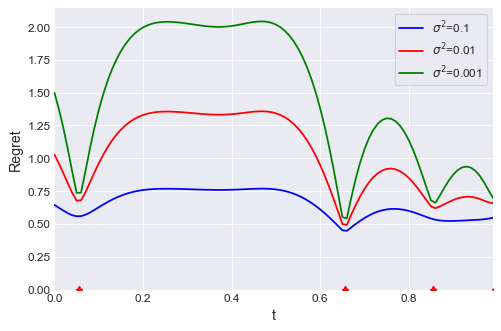

In [10]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
colors = ['b', 'r', 'g', 'y', 'p']
for regret, sigma_square, color in zip(regret_list, sigma_squares, colors):
    ax.plot(res['x_test'], regret, color=color, label=r"$\sigma^2$={}".format(sigma_square))
    ax.plot(x_train, [0] * len(y_train), "r*")
    ax.set_ylabel('Regret')
    ax.legend(loc=1)
ax.set_xlabel('t')
plt.xlim(res['x_test'][0], res['x_test'][-1])
plt.ylim(bottom=0)
plt.tight_layout()
plt.plot()


## Evaluate specific sample

In [11]:
x_to_eval = 0.1
sigma_squares = np.linspace(10, 1e-3)


In [12]:
# Simulation
genie_file = osp.join(res['genies_output_path'], f'genies_outputs_{x_to_eval}.npy')
nfs_simulation = [calc_nf_from_single_genie_file(genie_file,
                                                 sigma_square)[0] for sigma_square in sigma_squares]

# Anlytical

# Calculate analytical regret
phi_test = data_h.convert_point_to_features(x_to_eval, model_deg)
nfs_anlytic = [calc_analytic_norm_factor(phi_train,
                                         phi_test,
                                         theta_mn, sigma_square) for sigma_square in sigma_squares]
nf0s = [calc_gamma_0_norm_factor(phi_train, phi_test) for sigma_square in sigma_squares]


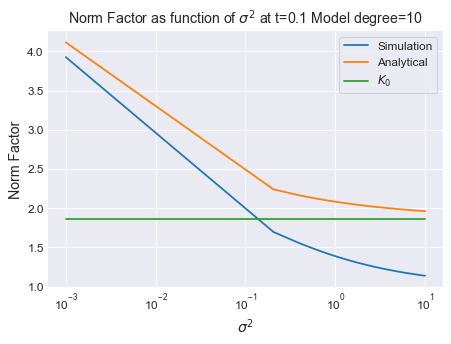

In [13]:
plt.plot(sigma_squares, nfs_simulation, label='Simulation')
plt.plot(sigma_squares, nfs_anlytic, label='Analytical')
plt.plot(sigma_squares, nf0s, label=r'$K_0$')

# plt.xlim(sigma_sqaures[-1], sigma_sqaures[0])  # decreasing time
plt.legend()
plt.xscale('log')
plt.xlabel(f'$\sigma^2$')
plt.ylabel('Norm Factor')
plt.title('Norm Factor as function of $\sigma^2$ at t={} Model degree={}'.format(x_to_eval, model_deg))
plt.show()


## For all model degress

In [14]:
# Choosing which simulation to analyze 
res = res_list[2]
x_train, y_train = res['x_train'], res['y_train']
model_deg = res['model_degree']
print('model_degree={} x_train={}'.format(x_train, model_deg))
sigma_square = res['params']['min_sigma_square']


model_degree=[0.055, 0.655, 0.855, 0.995] x_train=10


In [15]:
# Create data
DataC = data_utils.data_type_dict[res['params']['data_type']]
data_h = DataC(x_train, y_train, model_deg)
phi_train = data_h.phi_train

# Calculate minimum norm solution
pnml_h = PnmlMinNorm(1.0, phi_train, y_train, 0.0, sigma_square)
theta_mn = pnml_h.theta_erm

# Calculate analytical regret
phi_tests = [data_h.convert_point_to_features(x, model_deg) for x in res['x_test']]
nfs = [calc_analytic_norm_factor(phi_train, phi_test, theta_mn, sigma_square) for phi_test in phi_tests]
regrets = np.log(norm_factors)

# Regret when \sigma^2 -> \inf
nf0s = [calc_gamma_0_norm_factor(phi_train, phi_test) for phi_test in phi_tests]
regrets_0 = np.log(nf0s)

x_bot_square = [calc_x_bot_square(phi_train, phi_test) for phi_test in phi_tests]


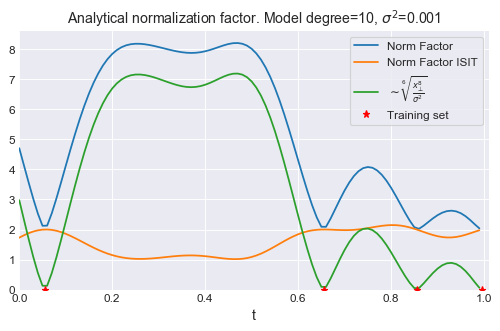

In [38]:
fig, ax = plt.subplots(1, 1)
ax.plot(res["x_test"], nfs, label='Norm Factor')
ax.plot(res["x_test"], nf0s, label=r'Norm Factor ISIT')
ax.plot(res["x_test"], np.array(nfs)-nf0s, label=r'$\sim \sqrt[6]{\frac{x_{\bot}^8}{\sigma^2}}$')
# ax.plot(res["x_test"], x_bot_square, label=r'$x_{\bot}^2$')
ax.plot(x_train, [0] * len(y_train), "r*", label='Training set')
ax.set_ylim(bottom=0.0)
ax.set_xlabel("t")
# ax.set_ylabel('Norm Factor')
ax.set_xlim(0.0,1.01)
plt.title('Analytical normalization factor. Model degree={}, $\sigma^2$={}'.format(model_deg,sigma_square))
plt.legend()
plt.tight_layout()
plt.show()
